# CNN Daily Mail Summarization using Google Pegasus-xum

Text summarization is a subfield of Natural Language Processing (NLP) and plays a crucial role in information retrieval, content analysis, and user interaction.

There are two main types of text summarization:

1. Extractive Summarization:

    * Selects and combines the most important sentences or phrases from the original text.

    * It doesn't generate new sentences, just pulls from the existing content.


2.  Abstractive Summarization:

    * Generates new sentences to convey the key ideas, similar to how humans summarize.

    * Involves rephrasing and paraphrasing.





The CNN / DailyMail Dataset is an English-language dataset containing just over 300k unique news articles as written by journalists at CNN and the Daily Mail. The current version supports both extractive and abstractive summarization.

# Setting up The Notebook and Installing Required Dependcies

In [1]:
pip install evaluate bert_score rouge_score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.6 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━

In [2]:
pip install --upgrade nvidia-cudnn-cu12

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.7/571.7 MB 2.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-cudnn-cu12
    Found existing installation: nvidia-cudnn-cu12 9.1.0.70
    Uninstalling nvidia-cudnn-cu12-9.1.0.70:
      Successfully uninstalled nvidia-cudnn-cu12-9.1.0.70
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.11.0.98 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from transformers import PegasusTokenizer, TFPegasusForConditionalGeneration, pipeline
from datasets import Dataset
from evaluate import load
import time
import os


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


2025-07-29 21:51:41.601769: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753825901.801353      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753825901.863560      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/validation.csv
/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/train.csv
/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/test.csv


In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Data Wrangling and Preprocessing

In [6]:
train_df = pd.read_csv('/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/train.csv')
train_df.head()

,id,article,highlights
0,0001d1afc246a7964130f43ae940af6bc6c57f01,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,0002095e55fcbd3a2f366d9bf92a95433dc305ef,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,00027e965c8264c35cc1bc55556db388da82b07f,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,0002c17436637c4fe1837c935c04de47adb18e9a,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,0003ad6ef0c37534f80b55b4235108024b407f0b,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...


In [7]:
# dropping the id field as it is not necessary

train_df.drop('id', axis=1, inplace=True)
train_df

,article,highlights
0,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...
...,...,...
287108,By . James Rush . Former first daughter Chelse...,Chelsea Clinton said question of running for o...
287109,An apologetic Vanilla Ice has given his first ...,"Vanilla Ice, 47 - real name Robert Van Winkle ..."
287110,America's most lethal sniper claimed he wished...,America's most lethal sniper made comment in i...
287111,"By . Sara Malm . PUBLISHED: . 12:19 EST, 8 Mar...",A swarm of more than one million has crossed b...


In [8]:
# no missing values

train_df.isnull().sum()

article       0
highlights    0
dtype: int64

In [9]:
# taking a 20K sample for training due to resources limitations

train_df = train_df.rename(columns={"article": "document", "highlights": "summary"})

dataset = Dataset.from_pandas(train_df.sample(20000, random_state=42))

google pegasus-xsum is a pretrained abstractive text summarization model developed by Google Research. It's part of the PEGASUS family, which was designed specifically for high-quality summarization tasks using transformer-based architectures.

PEGASUS is a Transformer-based encoder-decoder model tailored for summarization. Its innovation lies in the Gap Sentence Generation pretraining strategy, while its architecture remains similar to other Transformer models, making it powerful and transferable across summarization tasks.

In [10]:
model_name = "google/pegasus-xsum"

tokenizer = PegasusTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

In [11]:
# tokenizing the articles and summaries

max_input_length = 512
max_target_length = 64

def preprocess(example):
    inputs = tokenizer(
        example["document"],
        max_length=max_input_length,
        truncation=True,
        padding="max_length",
        return_tensors="tf"
    )
    targets = tokenizer(
        example["summary"],
        max_length=max_target_length,
        truncation=True,
        padding="max_length",
        return_tensors="tf"
    )

    inputs["labels"] = targets["input_ids"]
    return inputs

start_time = time.time()

train_dataset = dataset.map(preprocess, batched=True)

end_time = time.time()
print(f"Execution time: {(end_time - start_time)/60:.2f} minutes")

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

I0000 00:00:1753825969.211239      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753825969.212081      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Execution time: 1.53 minutes


In [12]:
# converting the dataset to a tf_dataset

def convert_to_tf_dataset(dataset):
    return tf.data.Dataset.from_tensor_slices(({
        "input_ids": dataset["input_ids"],
        "attention_mask": dataset["attention_mask"],
        "labels": dataset["labels"]
    }
    ))

# using batch size of 2 to reduce the memory required

batch_size = 2

start_time = time.time()

tf_train_dataset = convert_to_tf_dataset(train_dataset).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

end_time = time.time()
print(f"Execution time: {(end_time - start_time)/60:.2f} minutes")

Execution time: 0.60 minutes


In [13]:
strategy = tf.distribute.MirroredStrategy()


# ignoring positions marked with -100 in y_true to prevent the model from learning from padded parts of the output sequence.
def masked_loss(y_true, y_pred):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction="none")
    loss = loss_fn(y_true, y_pred)
    mask = tf.cast(y_true != -100, loss.dtype)
    loss *= mask
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)


# Adafactor is a more memory efficient variation Adam Optimizer
with strategy.scope():
    model = TFPegasusForConditionalGeneration.from_pretrained(model_name)
    model.compile(optimizer=tf.keras.optimizers.Adafactor(),
                  loss=masked_loss)
    model.summary()

tf_model.h5:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFPegasusForConditionalGeneration.

Some layers of TFPegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['final_logits_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/259 [00:00<?, ?B/s]

Model: "tf_pegasus_for_conditional_generation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (TFPegasusMainLayer)  multiple                  569748480 
                                                                 
 final_logits_bias (BiasLay  multiple                  96103     
 er)                                                             
                                                                 
Total params: 569844583 (2.12 GB)
Trainable params: 569748480 (2.12 GB)
Non-trainable params: 96103 (375.40 KB)
_________________________________________________________________


# Benchmarking Model Performance before Tuning

**Performance Metrics:**


**1. Rouge:**


   * ROUGE measures overlap between the candidate and reference summaries in terms of n-grams, sequences, and word pairs.
   * ROUGE-1: Overlap of single words (unigrams)
   * ROUGE-2: Overlap of two-word sequences (bigrams)
   * ROUGE-L (Longest Common Subsequence): Measures the longest sequence of words that appears in both the candidate and reference in the same order (not necessarily consecutive), Focuses more on fluency and structure.
   * ROUGE-LSUM: which measures the Longest Common Subsequence (LCS) between a reference and generated text.

   

**2. Bert Score:**

   * BERTScore evaluates the semantic similarity between the generated text (candidate) and the reference using deep contextual embeddings from pretrained BERT models.
   * Precision: how well the generated text aligns with the reference
   * Recall: how well the reference is captured in the generated text
   * F1-Score: harmonic mean of precision and recall
    

In [14]:
start_time = time.time()


validation_df = pd.read_csv('/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/validation.csv')
validation_df.drop('id', axis=1, inplace=True)
validation_df = validation_df.rename(columns={"article": "document", "highlights": "summary"})

validation_dataset = Dataset.from_pandas(validation_df.sample(1000, random_state=42))
validation_dataset = validation_dataset.map(preprocess, batched=True)
tf_validation_dataset = convert_to_tf_dataset(validation_dataset).shuffle(1000).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

end_time = time.time()
print(f"Execution time: {(end_time - start_time)/60:.2f} minutes")

tf_validation_dataset

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Execution time: 0.13 minutes


<_PrefetchDataset element_spec={'input_ids': TensorSpec(shape=(2, 512), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(2, 512), dtype=tf.int32, name=None), 'labels': TensorSpec(shape=(2, 64), dtype=tf.int32, name=None)}>

In [15]:
# calculate loss

start_time = time.time()


total_loss = 0.0
num_batches = 0

for batch in tf_validation_dataset:
    num_batches += 1

    outputs = model(
        input_ids=batch["input_ids"],
        attention_mask=batch["attention_mask"],
        labels=batch["labels"],
        training=False
    )

    loss = outputs.loss

    total_loss += loss.numpy()


end_time = time.time()
print(f"Execution time: {(end_time - start_time)/60:.2f} minutes")

pre_tuning_avg_val_loss = total_loss / num_batches
print(f"Pre Tuning Validation Loss: {pre_tuning_avg_val_loss[0]}")

Execution time: 10.77 minutes
Pre Tuning Validation Loss: 3.1233458518981934


In [16]:
# generate summaries

start_time = time.time()

pre_tuning_preds = []
all_refs = []


for batch in tf_validation_dataset:

    
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]

    
    with strategy.scope():
        generated_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=64,
            num_beams=4,
            early_stopping=True
        )


    decoded_preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
    pre_tuning_preds.extend(decoded_preds)


    decoded_labels = tokenizer.batch_decode(
        tf.where(labels == -100, tokenizer.pad_token_id, labels),
        skip_special_tokens=True
    )
    all_refs.extend(decoded_labels)



end_time = time.time()
print(f"Execution time: {(end_time - start_time)/60:.2f} minutes")

Execution time: 5.13 minutes


In [17]:
# rouge score

rouge = load("rouge")

start_time = time.time()


pre_tuning_rouge_results = rouge.compute(predictions=pre_tuning_preds, references=all_refs)
print(pre_tuning_rouge_results)


end_time = time.time()
print(f"Execution time: {(end_time - start_time)/60:.2f} minutes")

{'rouge1': 0.23768329832694893, 'rouge2': 0.08185702144517037, 'rougeL': 0.16956463563352142, 'rougeLsum': 0.16811891998029393}
Execution time: 0.00 minutes


In [18]:
# bert score

bertscore = load("bertscore")

start_time = time.time()

pre_tuning_bert_results = bertscore.compute(predictions=pre_tuning_preds, references=all_refs, lang="en", device="cpu")

pre_tuning_precision_mean = np.mean(pre_tuning_bert_results["precision"])
pre_tuning_recall_mean = np.mean(pre_tuning_bert_results["recall"])
pre_tuning_f1_mean = np.mean(pre_tuning_bert_results["f1"])


end_time = time.time()
print(f"Execution time: {(end_time - start_time)/60:.2f} minutes")

print(f"Pre Tuning Precision Mean: {pre_tuning_precision_mean:.4f}")
print(f"Pre Tuning Recall Mean:    {pre_tuning_recall_mean:.4f}")
print(f"Pre Tuning F1 Mean:        {pre_tuning_f1_mean:.4f}")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Execution time: 0.43 minutes
Pre Tuning Precision Mean: 0.8796
Pre Tuning Recall Mean:    0.8376
Pre Tuning F1 Mean:        0.8580


# Model Fine Tuning

In [19]:
import gc


# garbage collection before training to prevent OOM error

gc.collect()

275

In [20]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='/kaggle/working/checkpoints/best_model',
    monitor='loss',
    mode='min',
    save_best_only=True)

# training the model by passing all the samples once

history = model.fit(
    tf_train_dataset,
    epochs=40,
    steps_per_epoch= 500,
    batch_size=2,
    verbose=1,
    callbacks=[model_checkpoint]
)

# the training stopped after 20 epochs only as the dataset is exhusted during training
# this is due to that each step takes 2 samples (2 samples per batch)

Epoch 1/40


I0000 00:00:1753827612.993785     128 service.cc:148] XLA service 0x7a38ec00e5f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753827612.994541     128 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753827612.994568     128 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1753827613.146393     128 cuda_dnn.cc:529] Loaded cuDNN version 91100
I0000 00:00:1753827613.146412     131 cuda_dnn.cc:529] Loaded cuDNN version 91100
I0000 00:00:1753827613.482848     131 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


500/500 [==============================] - 1214s 1s/step - loss: 2.6303
Epoch 2/40
500/500 [==============================] - 634s 1s/step - loss: 2.0439
Epoch 3/40
500/500 [==============================] - 631s 1s/step - loss: 2.0028
Epoch 4/40
500/500 [==============================] - 626s 1s/step - loss: 1.9712
Epoch 5/40
500/500 [==============================] - 623s 1s/step - loss: 1.9918
Epoch 6/40
500/500 [==============================] - 623s 1s/step - loss: 2.0067
Epoch 7/40
500/500 [==============================] - 625s 1s/step - loss: 1.9446
Epoch 8/40
500/500 [==============================] - 623s 1s/step - loss: 1.9429
Epoch 9/40
500/500 [==============================] - 627s 1s/step - loss: 2.0000
Epoch 10/40
500/500 [==============================] - 626s 1s/step - loss: 1.9603
Epoch 11/40
500/500 [==============================] - 632s 1s/step - loss: 1.9212
Epoch 12/40
500/500 [==============================] - 629s 1s/step - loss: 1.9710
Epoch 13/40
500/500 [==

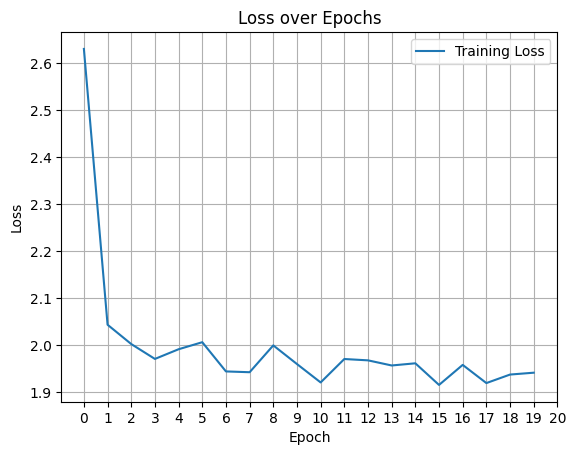

In [23]:
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Loss over Epochs')
plt.xticks(range(len(history.history['loss'])))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Loading Best Weights and Analyzing The Model Performance

In [24]:
model.load_weights('/kaggle/working/checkpoints/best_model')

In [25]:
start_time = time.time()

total_loss = 0.0
num_batches = 0

for batch in tf_validation_dataset:
    
    num_batches += 1
        
    outputs = model(
        input_ids=batch["input_ids"],
        attention_mask=batch["attention_mask"],
        labels=batch["labels"],
        training=False
    )

    loss = outputs.loss

    total_loss += loss.numpy()


end_time = time.time()
print(f"Execution time: {(end_time - start_time)/60:.2f} minutes")

post_tuning_avg_val_loss = total_loss / num_batches
print(f"Pre Tuning Validation Loss: {pre_tuning_avg_val_loss[0]}")
print(f"Post Tuning Validation Loss: {post_tuning_avg_val_loss[0]}")

Execution time: 9.80 minutes
Pre Tuning Validation Loss: 3.1233458518981934
Post Tuning Validation Loss: 1.8427021503448486


In [32]:
start_time = time.time()

post_tuning_preds = []
post_tunung_refs = []
num_batches = 0

for batch in tf_validation_dataset:
  
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]

    
    with strategy.scope():
        generated_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=64,
            num_beams=4,
            early_stopping=True
        )

    
    decoded_preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
    post_tuning_preds.extend(decoded_preds)

    decoded_labels = tokenizer.batch_decode(
    tf.where(labels == -100, tokenizer.pad_token_id, labels),
    skip_special_tokens=True
    )
    post_tunung_refs.extend(decoded_labels)


end_time = time.time()
print(f"Execution time: {(end_time - start_time)/60:.2f} minutes")

Execution time: 9.05 minutes


In [33]:
start_time = time.time()

post_tuning_rouge_results = rouge.compute(predictions=post_tuning_preds, references=post_tunung_refs)

end_time = time.time()
print(f"Execution time: {(end_time - start_time)/60:.2f} minutes")


print('Post Tuning Rouge')
print(post_tuning_rouge_results)
print('Pre Tuning Rouge')
print(pre_tuning_rouge_results)

Execution time: 0.00 minutes
Post Tuning Rouge
{'rouge1': 0.4036214053426081, 'rouge2': 0.17220537144910752, 'rougeL': 0.27938915044075807, 'rougeLsum': 0.27803206778843054}
Pre Tuning Rouge
{'rouge1': 0.23768329832694893, 'rouge2': 0.08185702144517037, 'rougeL': 0.16956463563352142, 'rougeLsum': 0.16811891998029393}


In [36]:
start_time = time.time()

post_tuning_bert_results = bertscore.compute(predictions=post_tuning_preds, references=post_tunung_refs, lang="en", device="cpu")

post_tuning_precision_mean = np.mean(post_tuning_bert_results["precision"])
post_tuning_recall_mean = np.mean(post_tuning_bert_results["recall"])
post_tuning_f1_mean = np.mean(post_tuning_bert_results["f1"])

end_time = time.time()
print(f"Execution time: {(end_time - start_time)/60:.2f} minutes")

print(f"Post Tuning Precision Mean: {post_tuning_precision_mean:.4f} \t-\t Pre Tuning Precision Mean: {pre_tuning_precision_mean:.4f}")
print(f"Post Tuning Recall Mean:    {post_tuning_recall_mean:.4f} \t-\t Pre Tuning Recall Mean:    {pre_tuning_recall_mean:.4f}")
print(f"Post Tuning F1 Mean:        {post_tuning_f1_mean:.4f} \t-\t Pre Tuning F1 Mean:        {pre_tuning_f1_mean:.4f}")

Execution time: 0.10 minutes
Post Tuning Precision Mean: 0.8803 	-	 Pre Tuning Precision Mean: 0.8796
Post Tuning Recall Mean:    0.8806 	-	 Pre Tuning Recall Mean:    0.8376
Post Tuning F1 Mean:        0.8803 	-	 Pre Tuning F1 Mean:        0.8580


In [37]:
model.save_pretrained("/kaggle/working/pegasus-finetuned-tf")
tokenizer.save_pretrained("/kaggle/working/pegasus-finetuned-tf")

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 64, 'num_beams': 8, 'length_penalty': 0.6}
  warnings.warn(


('/kaggle/working/pegasus-finetuned-tf/tokenizer_config.json',
 '/kaggle/working/pegasus-finetuned-tf/special_tokens_map.json',
 '/kaggle/working/pegasus-finetuned-tf/spiece.model',
 '/kaggle/working/pegasus-finetuned-tf/added_tokens.json')

# Pipeline Inferance

In [38]:
summarizer = pipeline("summarization", model="/kaggle/working/pegasus-finetuned-tf", tokenizer="/kaggle/working/pegasus-finetuned-tf", framework="tf")

All model checkpoint layers were used when initializing TFPegasusForConditionalGeneration.

All the layers of TFPegasusForConditionalGeneration were initialized from the model checkpoint at /kaggle/working/pegasus-finetuned-tf.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFPegasusForConditionalGeneration for predictions without further training.
Device set to use 0


In [44]:
text = validation_dataset[0]['document']

summary = summarizer(text)[0]["summary_text"]

print('predicted summary: ', summary)
print('\nactual summary: ', validation_dataset[0]['summary'])
print('\narticle: ', text)

predicted summary:  The Jerdon's Babbler was last spotted in Myanmar in 1941 and was thought to have died out altogether . But a team of scientists managed to uncover multiple birds in a small area of grassland in Myanmar's central Bago region . They used a recording of a Jerdon's Babbler

actual summary:  Was last spotted in Burma in 1941,and was thought to have died out .
Scientists used a recording of its distinctive call to rediscover species .
Discovery proves bird and habitat both still exist in Myanmar .

article:  A bird that was long thought to have gone extinct has been rediscovered in Burma after a team of scientists used a recording of the species' distinctive call to track it down. The Jerdon's Babbler (chrysomma altirostre altirostre) - a small brown bird similar in size to a house sparrow - was last spotted in Myanmar in 1941 and was thought to have died out altogether. But a team of scientists managed to uncover multiple birds nesting in a small area of grassland in Mya

In [53]:
text = validation_dataset[1]['document']


summary = summarizer(text)[0]["summary_text"]

print('predicted summary: ', summary)
print('\nactual summary: ', validation_dataset[1]['summary'])
print('\narticle: ', text)

predicted summary:  Balian Sukumaran was diagnosed with terminal liver disease in 2010 . Convicted drug smuggler Andrew Chan offered his own liver up for transplant . Mr Feebrey and Sukumaran are currently on Nusakambangan island, where they await clemency .

actual summary:  Pastor Mal Feebrey discovered he had terminal liver disease in 2010 .
He had developed a close friendship with Bali Nine kingpin Andrew Chan .
When Chan learnt of his condition, he immediately offered his own liver .
'He was sort of like, if they want to kill me, then you can have my liver'
He received another donation but said he would never forget the gesture .
Mr Feebrey said it would be tragic if Chan and Sukumaran were executed .
The pair's appeal for clemency will recommence Thursday March 20 .

article:  A Sydney pastor has spoken about the incredible moment Bali Nine ringleader Andrew Chan offered a vital piece of himself in a bid to save the man's life. Mal Feebrey, a men's mental health ambassador, had b

In [56]:
text = validation_dataset[2]['document']

summary = summarizer(text)[0]["summary_text"]

print('predicted summary: ', summary)
print('\nactual summary: ', validation_dataset[2]['summary'])
print('\narticle: ', text)

predicted summary:  Everton and Dynamo Kiev meet in their Europa League last-16 second leg . Toffees players train on the running track surrounding the playing surface . Roberto Martinez says the pitch is a 'concern' for both teams .

actual summary:  Everton take on Dynamo Kiev in the Europa League last 16 .
The Toffees currently lead the tie 2-1 on aggregate .
Martinez says the poor condition of the pitch will cause problems .

article:  Everton boss Roberto Martinez feels the poor condition of the pitch at Dynamo Kiev's Olympic Stadium is 'a concern' - but he is sure it will be just as problematic for one side as the other in Thursday's Europa League last-16 second-leg encounter. Rather than training on the pitch at their opponents' stadium as they normally would, Martinez' men did a session on the running track surrounding the playing surface - while the turf was covered by a protective sheet - following their arrival in Ukraine on Wednesday. And when asked about the state of the g